###### TODO:

1.  Take MBDNL as the reference to quantify the error ( user relative error )

2.  Check for Cu and Alkaline Earth metals

3.  Find formal charges by beggar's analysis in MBDNL optimised geometry

4.  Consider absolute electronegetiy of each elements present also as a fetaure function ( for the mettalic things )

5.  Polarisibility 



In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [275]:
comp = "CsH"
d3 = pd.read_csv(f'd3/{comp}.csv')
mbd = pd.read_csv(f'mbd/{comp}.csv')


In [276]:
mbd.head()

,cell_length,energy,E-dispersion
0,6.49869,-18.203213,-0.15729
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


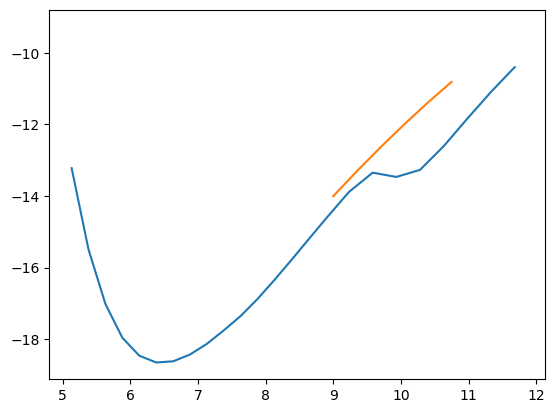

In [277]:
# plt.plot(cuppor['cell_length'], cuppor['energy'], 'o')
plt.plot(d3['cell_length'], d3['energy'])

# plt.plot(copper_mbd['cell_length'], copper_mbd['energy'], 'o')
plt.plot(mbd['cell_length'], mbd['energy'])

plt.show()

In [278]:


def compare_energy_data(d3, mbd, offset_ref_index=(6, 0), isPlot=False):
    """
    Compare energy differences between two datasets with different cell lengths.

    Parameters:
        d3 (pd.DataFrame): First dataset with 'cell_length' and 'energy' columns.
        mbd (pd.DataFrame): Second dataset with 'cell_length' and 'energy' columns.
        offset_ref_index (tuple): A tuple specifying indices for offset calculation 
                                  (index for data1['energy'], index for data2['energy']).
    
    Returns:
        pd.DataFrame: DataFrame with energy differences and interpolated values.
    """
    # Calculate offset based on specified reference indices
    offset = mbd['energy'][offset_ref_index[1]] - d3['energy'][offset_ref_index[0]]
    
    # Interpolate data2's energy values at data1's cell_length points
    mbd_interp = np.interp(d3['cell_length'], mbd['cell_length'], mbd['energy'])
    
    # Calculate the difference in energy values

    # handle the null values in mbd_interp
    mbd_interp = np.nan_to_num(mbd_interp)
    for i in range(len(mbd_interp)):
        if mbd_interp[i] == 0:
            mbd_interp[i] = d3['energy'][i]

    offset = np.nan_to_num(offset)
            
    # print(f"offset is {offset}")
    
    energy_diff =  mbd_interp - d3['energy'] - offset
    
    
    # Add the difference to the DataFrame for visualization
    result = d3.copy()
    result['energy_diff'] = energy_diff
    result['mbd_interp'] = mbd_interp
    # Plot the original data
    
    if isPlot:
        plt.figure(figsize=(10, 6))
        plt.plot(d3['cell_length'], d3['energy'], label='Data 1 (Reference)', marker='o')
        plt.plot(mbd['cell_length'], mbd['energy'], label='Data 2 (Original)', marker='x')
        plt.plot(d3['cell_length'], energy_diff, label='Energy Difference', linestyle='--')

        # Add labels and legend
        plt.xlabel('Cell Length')
        plt.ylabel('Energy')
        plt.title('Comparison of Energy vs Cell Length')
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()

    
    ans = max(result['energy_diff'])/ abs(mbd['energy'][offset_ref_index[1]])

    return ans*100


In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def optimize_polynomial_degree(data1, energy_diff, max_degree=10):
    """
    Optimize the polynomial degree by using cross-validation and selecting the best degree based on MSE.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (best_degree, best_mse) - The optimal polynomial degree and the corresponding MSE.
    """
    best_degree = None
    best_mse = float('inf')  # Start with an infinitely large MSE to minimize it
    
    # Prepare the data
    X = data1['cell_length'].values.reshape(-1, 1)
    y = energy_diff.values

    # Remove rows where y has NaN values
    valid_indices = ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]

    print(y)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    for degree in range(1, max_degree + 1):
        # Generate polynomial features for the current degree
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        X_val_poly = poly_features.transform(X_val)
        
        # Fit the model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val_poly)
        
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_val, y_pred)
        
        # If this MSE is better, update the best degree and MSE
        if mse < best_mse:
            best_mse = mse
            best_degree = degree


    
    print(f"Optimal Polynomial Degree: {best_degree} with MSE: {best_mse:.4f}")
    return best_degree, best_mse

def find_polynomial_maximum_with_optimal_degree(data1, energy_diff, max_degree=10):
    """
    Fit a polynomial regression to the data with an optimized degree and find the maximum value of the polynomial curve.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (max_cell_length, max_energy_diff) - The cell length and energy difference at the maximum.
    """
    # Remove rows with NaN values from energy_diff and align with data1
    valid_indices = energy_diff.dropna().index
    data1 = data1.loc[valid_indices].reset_index(drop=True)
    energy_diff = energy_diff.dropna().reset_index(drop=True)

    # Find the optimal polynomial degree
    # optimal_degree, _ = optimize_polynomial_degree(data1, energy_diff, max_degree=max_degree)
    
    optimal_degree = max_degree

    # Prepare the polynomial features for the optimal degree
    poly_features = PolynomialFeatures(degree=optimal_degree)
    X_poly = poly_features.fit_transform(data1['cell_length'].values.reshape(-1, 1))
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_poly, energy_diff)
    
    # Generate finer cell length values for extrapolation
    fine_cell_lengths = np.linspace(min(data1['cell_length']), max(data1['cell_length']), 500)
    fine_cell_lengths_poly = poly_features.transform(fine_cell_lengths.reshape(-1, 1))
    energy_diff_fine = model.predict(fine_cell_lengths_poly)
    
    # Calculate the first derivative (slope) of the fitted polynomial
    poly_coeffs = model.coef_[1:]  # Skip the first coefficient as it corresponds to the constant term
    first_derivative_coeffs = np.polyder(poly_coeffs)
    
    # Find the root of the first derivative (where slope = 0)
    critical_points = np.roots(first_derivative_coeffs)
    
    # We are interested in real roots that fall within the domain of the data
    critical_points_real = [point.real for point in critical_points if point.imag == 0 and min(data1['cell_length']) <= point.real <= max(data1['cell_length'])]
    
    # Evaluate the second derivative to check for maxima
    second_derivative_coeffs = np.polyder(first_derivative_coeffs)
    
    max_cell_length = None
    max_energy_diff = None
    
    for point in critical_points_real:
        # Evaluate the second derivative at each critical point to check for maximum (second derivative < 0)
        second_derivative_value = np.polyval(second_derivative_coeffs, point)
        if second_derivative_value < 0:  # This means it's a maximum
            max_cell_length = point
            max_energy_diff = np.polyval(poly_coeffs, point)
            break
    
    # Plot the original data and polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(data1['cell_length'], energy_diff, label='Energy Difference', linestyle='--', marker='o')
    plt.plot(fine_cell_lengths, energy_diff_fine, label=f'Polynomial Fit (Degree {optimal_degree})', linestyle='--')
    # plt.scatter(max_cell_length, max_energy_diff, color='red', label=f'Maximum at {max_cell_length:.3f}')
    
    # Add labels and legend
    plt.xlabel('Cell Length')
    plt.ylabel('Energy Difference')
    plt.title(f'Energy Difference and Polynomial Regression (Optimal Degree {optimal_degree})')
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

    return max_cell_length, max_energy_diff

# Example usage:
# Assuming `data1` is your dataframe with 'cell_length' and `energy_diff` is your computed energy difference
# max_cell, max_energy = find_polynomial_maximum_with_optimal_degree(data1, energy_diff)


In [280]:

ans = compare_energy_data(d3,mbd,offset_ref_index=(6,0))
ans

# first one is MBD



np.float64(6.935538754894319)

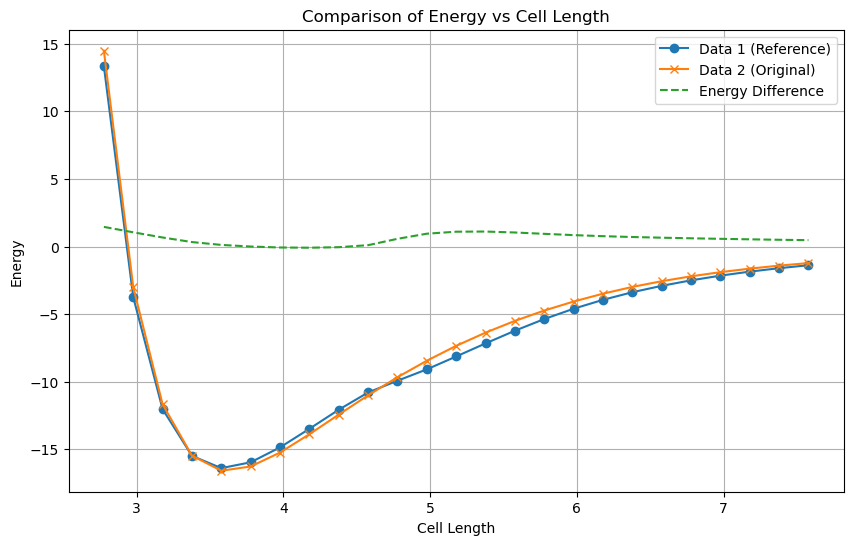

[np.float64(9.435266368199132),
 np.float64(10.446998825727952),
 np.float64(9.336508211442098),
 np.float64(6.935538754894319),
 np.float64(8.925098297331187)]

In [281]:

comps = ["LiH", "NaH", "KH", "CsH","Cu"]

res = []

for comp in comps:
    d3 = pd.read_csv(f'd3/{comp}.csv')
    mbd = pd.read_csv(f'mbd/{comp}.csv')
    if comp == "Cu":
        ans = compare_energy_data(d3,mbd,offset_ref_index=(5,5), isPlot=True)
    else:
        ans = compare_energy_data(d3,mbd,offset_ref_index=(6,0), isPlot=False)
    res.append(ans)
    # print(f"Max difference for {comp}: {ans}")

res

In [282]:
import itertools
import numpy as np

def generate_combinations(params, param_names, operators):
    results = []

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(params) + 1):
        for subset_indices in itertools.permutations(range(len(params)), r):  # Permutations of parameter indices
            subset = [params[i] for i in subset_indices]
            subset_names = [param_names[i] for i in subset_indices]

            if len(subset) == 1:
                expr_str = subset_names[0]
                expr_val = subset[0]
                results.append((expr_str, expr_val))
            else:
                for ops in itertools.product(operators, repeat=len(subset) - 1):
                    # Construct the expression as a string
                    expr_str = subset_names[0]
                    expr_val = subset[0]

                    for i in range(len(ops)):
                        expr_str += f" {ops[i]} {subset_names[i + 1]}"
                        if ops[i] == '*':
                            expr_val = expr_val * subset[i + 1]
                        elif ops[i] == '/':
                            expr_val = expr_val / subset[i + 1]
                    results.append((expr_str, expr_val))

    return results


In [283]:
""" 
    LiH , NaH , KH , CsH , Cu

"""
a = np.array([0.98, 0.93, 0.82, 0.79, 1.90])  # Cation electronegativity (Li, Na, K, Cs, Cu)
b = np.array([2.20, 2.20, 2.20, 2.20, 0])  # Anion electronegativity (H for all)

# Calculated values
c = a + b  # Sum of electronegativity
d = b - a  # Difference of electronegativity

# Polarizability values (from the provided table)
e = np.array([164.1125, 162.7, 289.7, 400.9, 46.5])  # Polarizability of cation (Li, Na, K, Cs, Cu)
f = np.array([4.50711, 4.50711, 4.50711, 4.50711, 0])  # Polarizability of H (common for all)

# Sum of polarizabilities
g = e + f

# Atomic radius values (in pm)
h = np.array([152, 186, 227, 343, 128])  # Atomic radius of cation (Li, Na, K, Cs, Cu)
i = np.array([53, 53, 53, 53, 0])       # Atomic radius of H (common for all)

# Coordination number (example data, based on compounds' common structure)
coordination_number = np.array([6, 6, 6, 6, 4])

In [ ]:

parameters = [a,b,c,d,e,f,g,h,i,coordination_number]
param_names = ['a', 'b', 'c', 'd', 'e','e','f','g','h','i','j']

# Define mathematical operators
operators = ['*', '/',]

# Generate and evaluate all expressions
all_expressions = generate_combinations(parameters, param_names, operators)

df = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

df.shape

C:\Users\user\AppData\Local\Temp\ipykernel_10268\2000937062.py:28: RuntimeWarning: divide by zero encountered in divide
  expr_val = expr_val / subset[i + 1]


(3165, 2)

In [285]:

values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)

In [286]:
values.head()

correlation = values.corr()

correlation = correlation[correlation['a'] == 1]
correlation.tail()

,a,b,c,d,e,a * b,a / b,a * c,a / c,a * d,...,e * d / c / b * a,e * d / c / b / a,e / d * c * b * a,e / d * c * b / a,e / d * c / b * a,e / d * c / b / a,e / d / c * b * a,e / d / c * b / a,e / d / c / b * a,e / d / c / b / a
a,1.0,-0.985772,-0.950725,-0.993403,-0.789452,-0.934474,1.0,0.88293,0.993666,-0.982995,...,-0.939428,-0.949923,-0.943149,-0.84359,-0.872045,-0.936646,-0.917876,-0.814589,-0.904893,-0.942455


### Feature functions to be used

1. Electronegetivities of each atom involded

2. sum of electronegetivities 

3. Difference of electronegetivities

4. polarisibility

6. Redox potentials 

7. Atomic raiis , sum of atomic raii

8. Formal Charges ( dont know how to take that )

9. Also should have test data 

10. coordination number